In [26]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [27]:
import pandas as pd

Taiwan_QQQ = pd.read_feather('Cleaned_2022_Reading.feather')

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Reading_level'], axis=1)
y = Taiwan_QQQ['Reading_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

MATHEFF       0.107934
ICTEFFIC      0.080701
ISCEDP        0.078422
ICTSUBJ       0.074529
ICTOUT        0.071169
                ...   
IC177Q05JA    0.019089
IC183Q02JA    0.018838
ST250Q03JA    0.018778
PERSEVAGR     0.018671
WORKHOME      0.018604
Length: 100, dtype: float64


In [29]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,MATHEFF,ICTEFFIC,ISCEDP,ICTSUBJ,ICTOUT,HOMEPOS,ICTWKEND,EXPECEDU,ICTREG,MATHEF21,...,IC177Q04JA,IC172Q03JA,LANGN,ST268Q01JA,IC176Q01JA,IC177Q05JA,IC183Q02JA,ST250Q03JA,PERSEVAGR,WORKHOME
116617,-1.5802,-2.6393,244.0,-1.0124,-1.8681,-1.2849,1.0960,6.0,0.9085,-1.5003,...,4.0,2.0,641.0,3.0,1.0,4.0,1.0,1.0,-0.5249,4.0
113200,-0.0701,1.9551,344.0,-0.1212,0.5817,0.7375,0.1378,8.0,0.8328,1.0780,...,3.0,2.0,641.0,3.0,5.0,2.0,4.0,1.0,2.7704,2.0
114431,-0.2596,1.9495,354.0,-1.0124,-0.6846,-1.4658,-1.5204,4.0,-1.0564,0.7073,...,1.0,2.0,641.0,2.0,3.0,2.0,4.0,1.0,-0.4753,6.0
116880,-3.4814,-1.1255,354.0,-2.0101,-2.5404,-2.0020,1.1959,7.0,-2.6720,-2.1867,...,2.0,2.0,641.0,1.0,1.0,4.0,2.0,2.0,-0.9259,4.0
114548,-3.4257,1.9495,244.0,-0.4015,-2.5404,-0.3491,1.9384,4.0,-2.6720,-2.1406,...,1.0,2.0,641.0,1.0,1.0,1.0,4.0,1.0,3.0554,10.0


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}


# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7961579509071505
Fold 2 score: 0.8068303094983992
Fold 3 score: 0.8036286019210246
Fold 4 score: 0.8046958377801494
Fold 5 score: 0.7993596584845251
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5314834578441836
Fold 2 score: 0.5314834578441836
Fold 3 score: 0.5304162219850587
Fold 4 score: 0.5314834578441836
Fold 5 score: 0.5304162219850587
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.7620064034151548
Fold 2 score: 0.7716115261472786
Fold 3 score: 0.7534685165421559
Fold 4 score: 0.7801494130202775
Fold 5 score: 0.7833511205976521
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.7961579509071505
Fold 2 score: 0.8068303094983992
Fold 3 score: 0.8036286019210246
Fold 4 score: 0.8046958377801494
Fold 5 score: 0.7993596584845251
Params: {'svm

In [31]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.791889007470651
Fold 2 score: 0.816435432230523
Fold 3 score: 0.8057630736392742
Fold 4 score: 0.7982924226254002
Fold 5 score: 0.8089647812166488
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.8025613660618997
Fold 2 score: 0.8196371398078975
Fold 3 score: 0.8100320170757738
Fold 4 score: 0.8100320170757738
Fold 5 score: 0.807897545357524
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.791889007470651
Fold 2 score: 0.8175026680896478
Fold 3 score: 0.807897545357524
Fold 4 score: 0.8153681963713981
Fold 5 score: 0.7972251867662753
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.7982924226254002
Fold 2 score: 0.81750266808964

In [32]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.7427961579509071
Fold 2 score: 0.7406616862326574
Fold 3 score: 0.7513340448239061
Fold 4 score: 0.7513340448239061
Fold 5 score: 0.7321237993596584
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.7620064034151548
Fold 2 score: 0.7630736392742796
Fold 3 score: 0.7620064034151548
Fold 4 score: 0.7737459978655283
Fold 5 score: 0.759871931696905
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.7822838847385272
Fold 2 score: 0.7801494130202775
Fold 3 score: 0.7844183564567769
Fold 4 score: 0.8046958377801494
Fold 5 score: 0.7705442902881536
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.7427961579509071
Fold 2 score: 0.7406616862326574
Fold 3 score

In [33]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.767342582710779
Fold 2 score: 0.7737459978655283
Fold 3 score: 0.7716115261472786
Fold 4 score: 0.7534685165421559
Fold 5 score: 0.7694770544290288
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.7716115261472786
Fold 2 score: 0.7833511205976521
Fold 3 score: 0.7801494130202775
Fold 4 score: 0.7588046958377801
Fold 5 score: 0.7694770544290288
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.7694770544290288
Fold 2 score: 0.7822838847385272
Fold 3 score: 0.7790821771611526
Fold 4 score: 0.7577374599786553
Fold 5 score: 0.7694770544290288
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.7705442902881536
Fold 2 score: 0.7833511205976521
Fold 3 score: 0.7790821771611526
Fold 4 score: 0.7588046958377801
Fold 5 score: 0.7705442902881536
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.7716115261472786
Fold 2 score: 0.7833511205976521
Fold 3 score: 0.7790821771611526
Fold 4 score: 0.7588046958377801
Fold 5 score: 0.7694770544290

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [34]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model.score(X_test, y_test)

0.8293515358361775

In [35]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

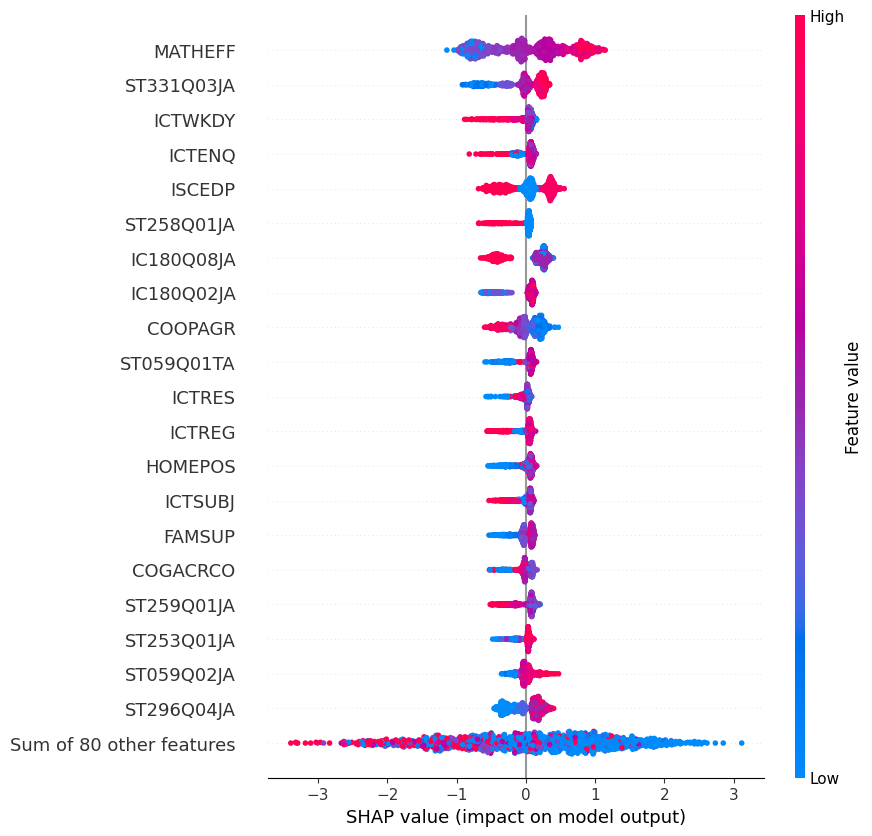

In [39]:
shap.plots.beeswarm(shap_values,max_display=21,order=shap_values.abs.max(0))

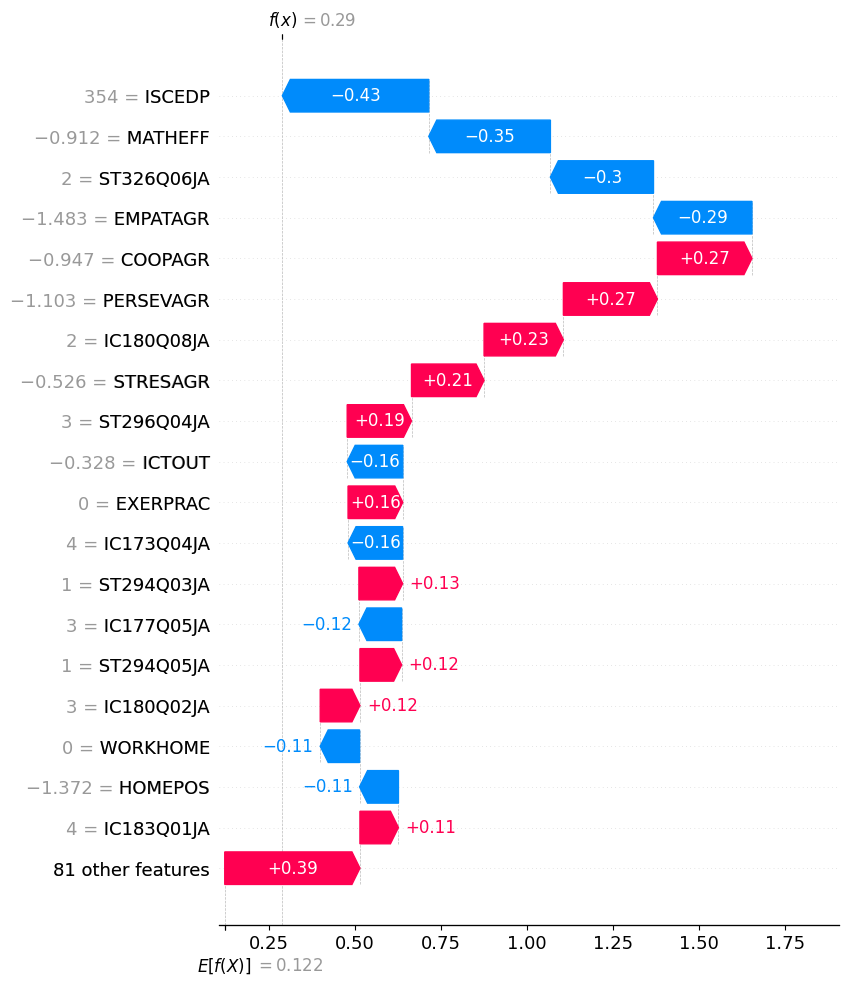

In [37]:
shap.plots.waterfall(shap_values[1], max_display=20)